Write a solver for the regularized $p$-Laplacian, 
$$ -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) = 0 $$ where $$ \kappa(\nabla u) = \big(\frac 1 2 \epsilon^2 + \frac 1 2 \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}}, $$
$ \epsilon \gt 0$, and $1 \lt p \lt \infty$. The case $p=2$ is the conventional Laplacian. This problem gets more strongly nonlinear when $p$ is far from 2 and when $\epsilon$ approaches zero. The $p \to 1$ limit is related to plasticity and has applications in non-Newtonion flows and structural mechanics.

1. Implement a "Picard" solver, which is like a Newton solver except that the Jacobian is replaced by the linear system 
$$ J_{\text{Picard}}(u) \delta u \sim -\nabla\cdot\big( \kappa(\nabla u) \nabla \delta u \big) . $$ 
This is much easier to implement than the full Newton linearization. 
How fast does this method converge for values of $p \lt 2$ and $p \gt 2$?

2. Use the linearization above as a preconditioner to a Newton-Krylov method. That is, use scipy.sparse.linalg.LinearOperator to apply the Jacobian to a vector 
$$ \tilde J(u) v = \frac{F(u + h v) - F(u)}{h} . $$ 
Then for each linear solve, use scipy.sparse.linalg.gmres and pass as a preconditioner, a direct solve with the Picard linearization above. (You might find scipy.sparse.linalg.factorized to be useful. Compare algebraic convergence to that of the Picard method.
3. Can you directly implement a Newton linearization? Either do it or explain what is involved. How will its nonlinear convergence compare to that of the Newton-Krylov method?

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
import scipy.sparse as sp
import scipy.sparse.linalg
pyplot.style.use('ggplot')

In [2]:
def hgrid(h):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    return x, y

We will discretize the divergence form and thus will need $\kappa(\nabla u)$ evaluated at staggered points  $(i-1/2,j)$, $(i,j-1/2)$, etc. We will calculate these using second order difference 
$$ (u_x)_{i-1/2,j} = \frac{u_{i,j} + u_{i-1,j}}{h} $$

In [3]:
def nonlinear2d_div(h, x, y, u, forcing, g0, dirichlet=((),()), eps=10, p=2):
    m = x.shape[0]
    u0 = g0(x, y).flatten()
    F = -forcing(x, y).flatten()
    ai = []
    aj = []
    av = []
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    
    def kappa_eval(grad_u, eps, p):
        return (0.5*eps**2+0.5*(grad_u)**2)**((p-2)/2)

    mask = numpy.ones_like(x, dtype=bool)
    mask[dirichlet[0],:] = False
    mask[:,dirichlet[1]] = False
    mask = mask.flatten()
    
    u = u.flatten()
    F[mask == False] = u[mask == False] - u0[mask == False]
    u[mask == False] = u0[mask == False]
    
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            # Stencil to evaluate gradient at four staggered points
            grad = numpy.array([[-1, 0, 1, 0, 0],
                                [0, -1, 1, 0, 0],
                                [0, 0, -1, 1, 0],
                                [0, 0, -1, 0, 1]]) / h

            # Stencil to compute divergence at cell centers from fluxes at four staggered points
            div = numpy.array([-1, -1, 1, 1]) / h
            ustencil = u[stencili]
            grad_ustag = grad @ ustencil
            kappa = kappa_eval(grad_ustag, eps, p)
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
            else:
                F[row] -= div @ (kappa[:,None] * grad @ ustencil)
                Jstencil = -div @ (kappa[:,None] * grad)
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask].tolist()
                av += Jstencil[smask].tolist()
    J = sp.csr_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return F, J

In [4]:
def solve_nonlinear(h, g0, dirichlet, atol=1e-8, verbose=False, eps=10, p=2):
    x, y = hgrid(h)
    u = 0*x
    for i in range(50):
        F, J = nonlinear2d_div(h, x, y, u, lambda x,y: 0*x+1,
                               lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)), eps=eps, p=p)
        anorm = numpy.linalg.norm(F, numpy.inf)
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
        deltau = sp.linalg.spsolve(J, -F)
        u += deltau.reshape(x.shape)
    return x, y, u, i

 0: anorm 1.000000e+00
 1: anorm 2.714364e-04
 2: anorm 8.436454e-08
 3: anorm 2.241762e-11


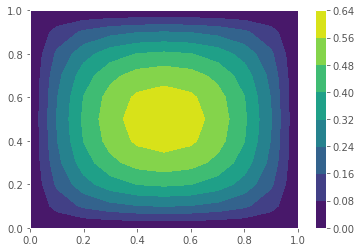

In [5]:
x, y, u, i = solve_nonlinear(.1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)), verbose=True, eps=100, p = 1.5)
pyplot.contourf(x, y, u)
pyplot.colorbar();

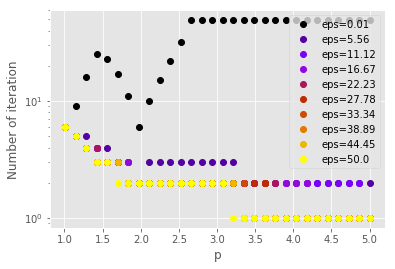

In [6]:
p_sample = numpy.linspace(1.01,5, 30)
eps_sample = numpy.linspace(0.01, 50, 10)

cmap = pyplot.get_cmap('gnuplot')
colors = [cmap(i) for i in numpy.linspace(0, 1, 10)]

for ind, eps_i in enumerate(eps_sample):
    num_it = []
    for p_i in p_sample:
        x, y, u, i = solve_nonlinear(.1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)), 
                                     verbose=False, eps=eps_i, p = p_i)
        num_it.append(i)
    pyplot.semilogy(p_sample, num_it, 'o', color = colors[ind],
                    label='eps='+str(numpy.round(eps_i,2)))
pyplot.legend(loc=0)
pyplot.xlabel('p')
pyplot.ylabel('Number of iteration')
pyplot.show()

For $p>2$ the method converge in 2 or 3 iterations, while for $p<2$ it needs more iteration to converge. For $\epsilon$ close to zero the method doesn't converge for $p>2,5$.

On each iteration of Newton method we have:
$$J^k_{picard} \delta u = -F^k(u)$$.
In the JFNK approach, a Krylov method is used to solve the linear system of these equations (Krylov iterations are performed at the fixed Newton iteration). The j-th GMRES iteration minimizes $||J\delta u_j +F(u)||_2$ in a least-squares sence.
$$\delta u_j = \delta u_0 + \sum_{i=0}^{j}\beta_i(J^i)r_0,$$
where $(J^i)r_0$ are Krylovs vectors and scalar $\beta_i$ minimizes residual.

Action of Jacobian in the form of matrix-vector products can be approximated as
$$ \tilde J(u) v = \frac{F(u + h v) - F(u)}{h} . $$ 

**Preconditioning**:

We can rewrite first equation as
$$(JP^{-1})(P \delta u) = -F(u),$$
where $P$ is preconditioning matrix.
We can introduce $w = (P \delta u)$, then
$$(JP^{-1})w = -F(u),$$
where 
$$(JP^{-1})w \approx \frac{F(u + h P^{-1} w) - F(u)}{h}.$$
And $\delta u = P^{-1}w$, so, in fact, we need to know only $P^{-1}$ and scipy.sparse.linalg.gmres takes $P^{-1}$ as preconditioning parameter.

In [7]:
def solve_JFNK_precondition(h, g0, dirichlet, atol=1e-8, verbose=False, eps=150, p=1.01):
# h = 0.1
# eps = 100
# p = 1.5
    x, y = hgrid(h)
    N = x.flatten().shape[0]
    u = 0*x

    for i in range(50):
        F, J_picard = nonlinear2d_div(h, x, y, u, lambda x,y: 0*x+1,
                               lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)), eps=eps, p=p)
        J_inv = scipy.sparse.linalg.factorized(J_picard)
        P_inv = scipy.sparse.linalg.LinearOperator((N,N), J_inv)
        def J_tild(v):
            Fv,_ = nonlinear2d_div(h, x, y, u + h * v.reshape(u.shape), lambda x,y: 0*x+1,
                                    lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)), eps=eps, p=p)
            return (Fv - F)/h
        Jv = scipy.sparse.linalg.LinearOperator((N,N), J_tild)
        du, info = scipy.sparse.linalg.gmres(Jv, -F, tol=1e-9, maxiter=50, M=P_inv)
        anorm = numpy.linalg.norm(F, numpy.inf)
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
        u += du.reshape(x.shape)
    return x, y, u, i


In [25]:
p = 4
eps = 1

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


 0: anorm 1.000000e+00
 1: anorm 5.959764e-01
 2: anorm 7.303548e-03
 3: anorm 6.621431e-04
 4: anorm 2.849359e-05
 5: anorm 1.201495e-06
 6: anorm 4.734161e-08
 7: anorm 2.139423e-09


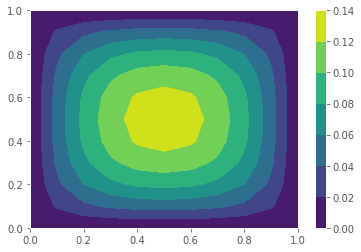

In [26]:
x, y, u1, i1 = solve_JFNK_precondition(.1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)), verbose=True, eps=eps, p = p)
pyplot.contourf(x, y, u1)
pyplot.colorbar();

 0: anorm 1.000000e+00
 1: anorm 6.144785e-01
 2: anorm 2.242665e-01
 3: anorm 8.341654e-02
 4: anorm 2.856358e-02
 5: anorm 9.543463e-03
 6: anorm 3.116813e-03
 7: anorm 1.005174e-03
 8: anorm 3.212716e-04
 9: anorm 1.020912e-04
10: anorm 3.231398e-05
11: anorm 1.020110e-05
12: anorm 3.214614e-06
13: anorm 1.011787e-06
14: anorm 3.181978e-07
15: anorm 1.000156e-07
16: anorm 3.142524e-08
17: anorm 9.871460e-09


1.1419849788030234e-10

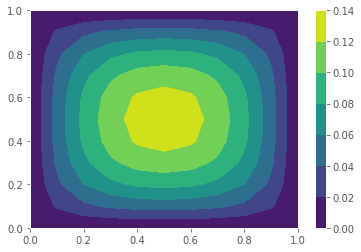

In [27]:
x, y, u2, i2 = solve_nonlinear(.1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)), verbose=True, eps=eps, p = p)
pyplot.contourf(x, y, u2)
pyplot.colorbar();

numpy.linalg.norm((u2 - u1).flatten(), numpy.inf)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


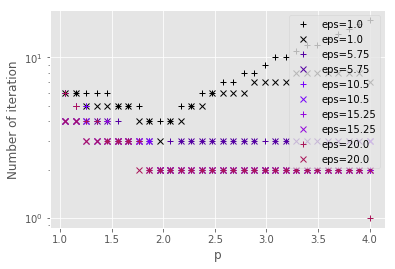

In [21]:
p_sample = numpy.linspace(1.05,4, 30)
eps_sample = numpy.linspace(1, 20, 5)

cmap = pyplot.get_cmap('gnuplot')
colors = [cmap(i) for i in numpy.linspace(0, 1, 10)]

for ind, eps_i in enumerate(eps_sample):
    num_it1 = []
    num_it2 = []
    for p_i in p_sample:
        x, y, u, i1 = solve_nonlinear(.1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)), 
                                     verbose=False, eps=eps_i, p = p_i)
        x, y, u, i2 = solve_JFNK_precondition(.1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)), 
                             verbose=False, eps=eps_i, p = p_i)
        num_it1.append(i1)
        num_it2.append(i2)
    pyplot.semilogy(p_sample, num_it1, '+', color = colors[ind],
                    label='eps='+str(numpy.round(eps_i,2)))
    pyplot.semilogy(p_sample, num_it2, 'x', color = colors[ind],
                    label='eps='+str(numpy.round(eps_i,2)))
pyplot.legend(loc=0)
pyplot.xlabel('p')
pyplot.ylabel('Number of iteration')
pyplot.show();

The number of iterations in most cases smaller for JFNK method. Espesially for small $\epsilon$.

To directly implement a Newton linearization, we need to calculate Jacobian without using Picard lianerization. Newton method has quadratic convergence. 